First I will introduce a novel ( in the sense that I came up with this and cannot find literature that uses this method. However, given its simplicity, I doubt this is actually new. I have not tried very hard to look for it in the existing literature either.) method for modelling transition between boxes that does not follow the exponential distribution. This method only works on models that models changes of discrete individuals, whether spatial or not. The basic idea is that the exit time is generated as the individual enters the current box, with only the infection (S -> E/C/I) ran with gillespie, and timestep is chosen to be min(np.exp(total rate of infection), exit_time_i - current_time), and the corresponding change in state is taken. This method could be further sped up if the transition between boxes does not concern change in infectivity, namingly the C-> I transition. This is because what we can do at each survey is to simply look at infected individuals such that the time of transition is less than the survey time. This can be quite flexible, different surveying scheme can be used including those which only samples part of the population or those that have certain false negative rate. This method means that multiple box model is only required when infectivity changes, and transtion between boxes can follow any distribution. below is the code for scanning through different culling radius with the transition time between C->I follows a Gamma distribution with fixed mean ( = 107) and with different scale parameter. Essentially, this is but a modified form of the gillespie first reaction algorithm.   All parameters comes from https://nph.onlinelibrary.wiley.com/doi/epdf/10.1111/nph.14488 with beta adjusted so that the calcuated dispersal kernel from alpha is normalized. It is possible to change the rate of movement between boxes back to exponential and indeed the same epidemic size with the box model is recovered.

Below is a code written in python. However, the code is ran more efficiently in julia. And the result from julia with y axis being the final epidemic size is ploted as:
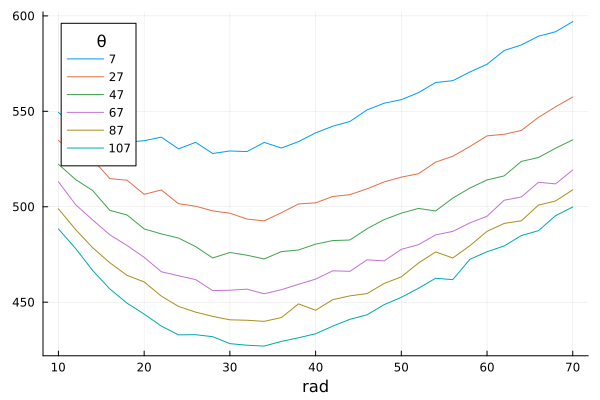

where each combination of the rate parameter $\theta$ and culling radius is repeated for 5000 times, and the resolution of culling radius is 2. 
Note when the rate parameter is 170, the latent period becomes exponentially distributed with mean 107, and hence should be identical to the original paper. It can be seen visually that the optimum remains in the same neighbourhood, and the overall shape similar, except with higher shape parameter, the expected end epidemic size is larger for the same control strategy. 

Below is the fuller picture with 1000 repetition and radius resolution of 5.

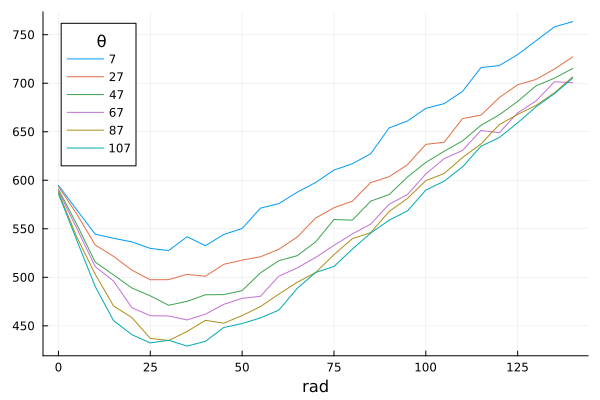

The julia code for this model can be found at https://github.com/wl415/Summer-project-on-time-dependent-infectivity-and-detectability/blob/main/scan%20epidemic%20size.jl

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy.random as rnd
import numexpr as ne

['C:\\Users\\wayne\\PycharmProjects\\SIR', 'C:\\Program Files\\Python38\\python38.zip', 'C:\\Program Files\\Python38\\DLLs', 'C:\\Program Files\\Python38\\lib', 'C:\\Program Files\\Python38', '', 'C:\\Users\\wayne\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\Users\\wayne\\AppData\\Roaming\\Python\\Python38\\site-packages\\win32', 'C:\\Users\\wayne\\AppData\\Roaming\\Python\\Python38\\site-packages\\win32\\lib', 'C:\\Users\\wayne\\AppData\\Roaming\\Python\\Python38\\site-packages\\Pythonwin', 'C:\\Program Files\\Python38\\lib\\site-packages']


In [4]:
b = 5.25288611787717
a = 37
num_repeat = 1000
max_cull_rad = 150
num_tree = 1111
tre = np.loadtxt("smallLandscape.txt")


def inverselogit(y, mu=107, k=0.02, l=1):
    return (-np.log(l / y - 1)/k) + mu


def logit(y, mu, k):
    return 1 / (1 + np.exp(-k * (y - mu)))


# dispersal kernel
def dispersal(alpha):
    dis = ne.evaluate("1/(1+(distance/alpha)**2)")
    factor = (np.sum(dis) - 1111) / 2
    dis = ne.evaluate('dis/factor')
    return b * dis


# pairwise distance matrix
distance = np.zeros([num_tree, num_tree])
for i in range(num_tree):
    for j in range(num_tree):
        distance[i, j] = ((tre[i, 0] - tre[j, 0]) ** 2 + (tre[i, 1] - tre[j, 1]) ** 2) ** 0.5
dispersing = dispersal(37)
dispersing[dispersing < 1e-10] = 0
cull_radiuses = range(max_cull_rad)
search = np.arange(0.005, 0.04, 0.005)
# data stores the final epidemic size with axis 0 the value of k, axis 1 the cull radius, and the last axis stores the repeats.
data = np.zeros([len(search), max_cull_rad, num_repeat])
for k in search:
    for cull_radius in cull_radiuses:
        for q in range(num_repeat):
            print(q)
            t = 0
            ts = [0]
            Ss = [1101]
            Cs = [10]
            Rs = [0]
            # data is organised so that tree[:, [0, 1]] is the coordinate, tree[:, 2] is the state with 0 = S, 1 = C, 2 = R
            # tree[:, 3] is the rate of change, or the propagule density that is only applicable to S
            # tree[:, 4] is the time of infection, and tree[:, 5] the time of becoming detectable
            tree = np.c_[tre, np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree)]
            initial = rnd.randint(0, num_tree, 10)
            tree[initial, 2] = 1
            tree[initial, 3] = 0
            # setting initial pressure and time to become detectable
            for i in initial:
                tree[i, 5] = inverselogit(rnd.uniform(logit(0, 107, k), 1), k=k)
                for j in np.where(tree[:, 2] == 0)[0]:
                    tree[j, 3] += dispersing[i, j]

            # loops
            while Cs[-1] > 0:
                # infection
                event = np.cumsum(tree[:, 3])
                rate = event[-1]
                if rate > 0:
                    timestep = rnd.exponential(1 / rate)
                else:
                    break
                nextcull = 90 - (t % 90)
                if nextcull < timestep:
                    # culling
                    # list of plant to be culled
                    culled = []
                    # trees that are detectable before the next cull are detected, if the tree is not infected or is already culled they are not culled
                    detected = np.logical_and(tree[:, 5] < t + nextcull, tree[:, 2] == 1)
                    for i in np.where(detected == 1)[0]:
                        for j in range(num_tree):
                            # note in this process the detected tree always have distance i, j = 0 and hence is added to the list
                            if distance[i, j] <= cull_radius and tree[j, 2] != 2:
                                culled.append(j)
                    # removing replicates
                    culled = list(dict.fromkeys(culled))
                    # update dispersal stress
                    for i in culled:
                        if tree[i, 2] == 1:
                            for j in range(num_tree):
                                if tree[j, 2] == 0:
                                    tree[j, 3] -= dispersing[i, j]
                    # cull tree
                    tree[culled, 2] = 2
                    tree[culled, 3] = 0
                    t = t + nextcull
                    ts.append(t)
                    Ss.append(sum(tree[:, 2] == 0))
                    Cs.append(sum(tree[:, 2] == 1))
                    Rs.append(sum(tree[:, 2] == 2))
                    #plt.scatter(tree[tree[:, 2] == 0, 0], tree[tree[:, 2] == 0, 1], color="b", s=0.2)
                    #plt.scatter(tree[tree[:, 2] == 1, 0], tree[tree[:, 2] == 1, 1], color="r", s=0.2)
                    #plt.scatter(tree[tree[:, 2] == 2, 0], tree[tree[:, 2] == 2, 1], color="black", s=0.2)
                    #plt.title(t)
                    #plt.show()
                # infection
                else:
                    t += timestep
                    ts.append(t)
                    whichevent = rate * rnd.rand()
                    which = np.argmax(event > whichevent)
                    tree[which, 2] += 1
                    tree[which, 3] = 0
                    tree[which, 4] = t
                    # time to be detected
                    tree[which, 5] = t + rnd.gamma(170/k, k)
                    # updating rate
                    tree[tree[:, 2] == 0, 3] = tree[tree[:, 2] == 0, 3] + dispersing[which, tree[:, 2] == 0]
                    Ss.append(Ss[-1] - 1)
                    Cs.append(Cs[-1] + 1)
                    Rs.append(Rs[-1])
            data[np.where(k == search), cull_radius, q] = Rs[-1]
    # print(k)




KeyboardInterrupt: 

Next we can plot the data to give an idea of final epidemic size.

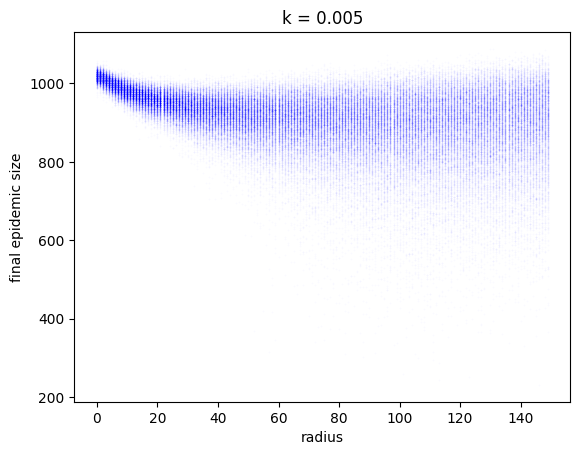

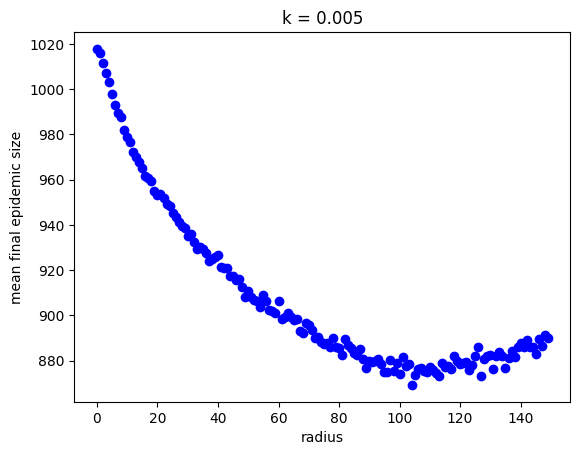

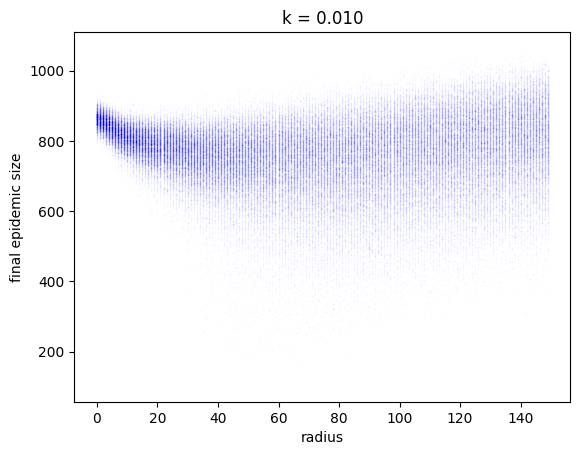

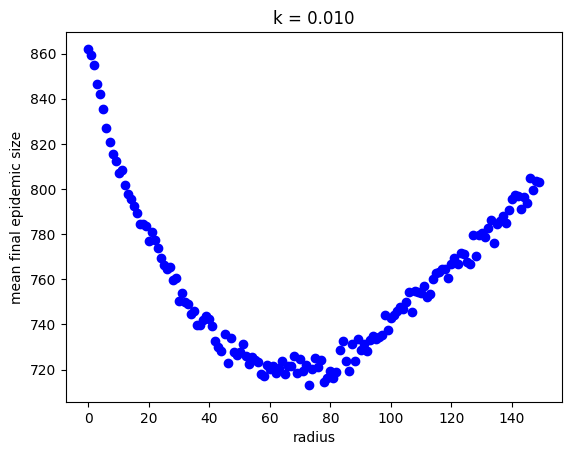

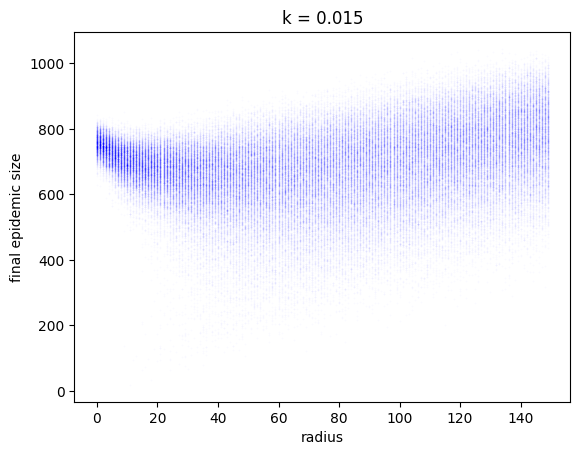

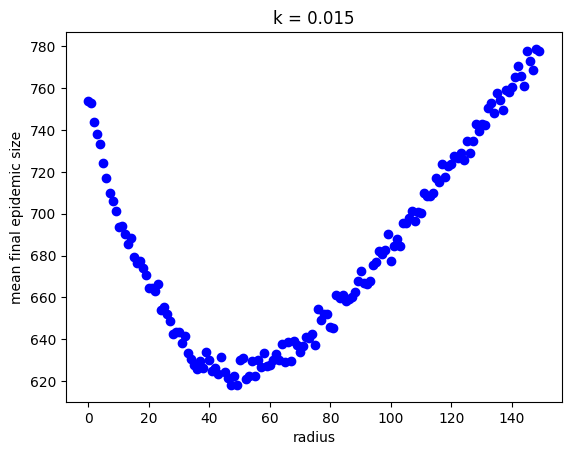

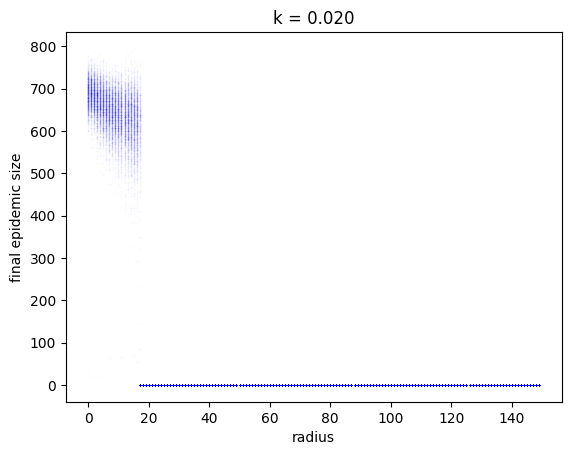

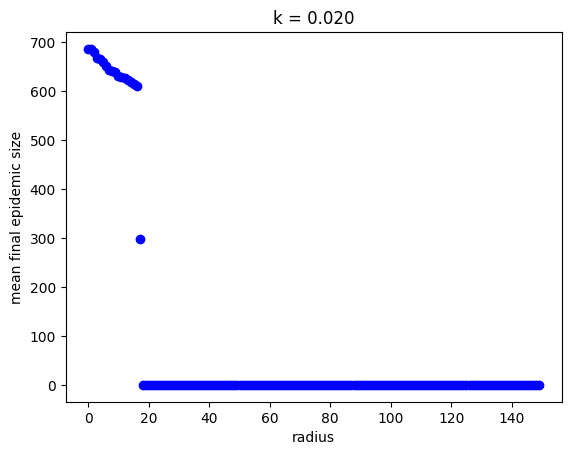

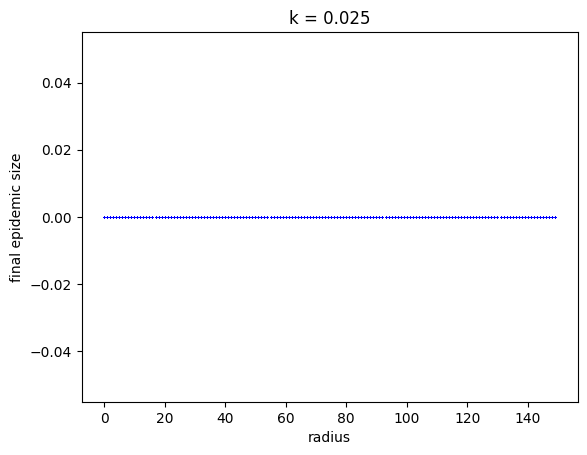

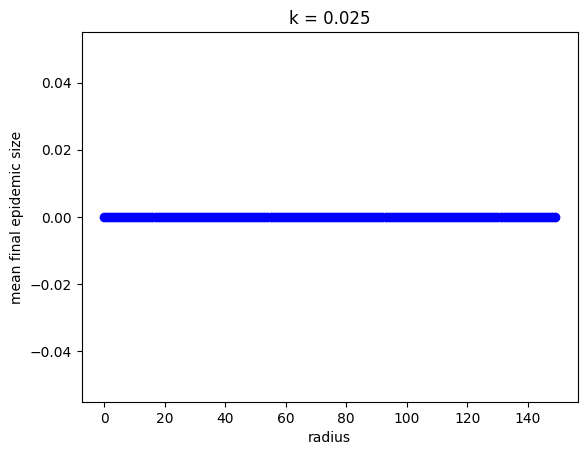

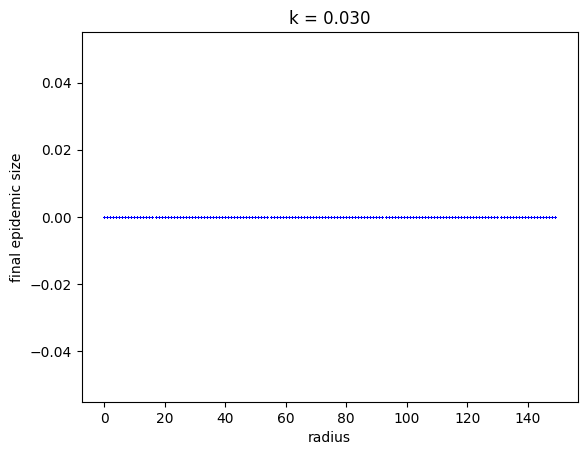

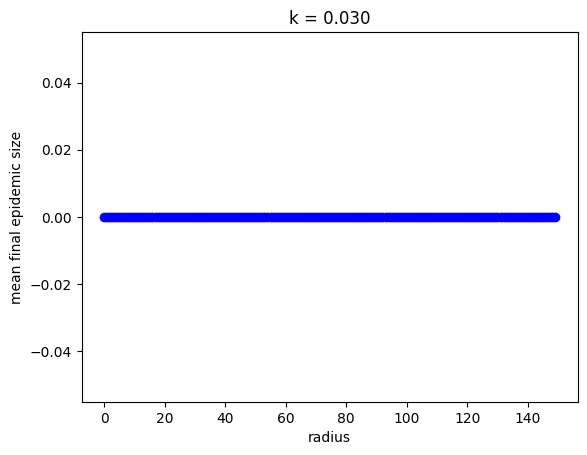

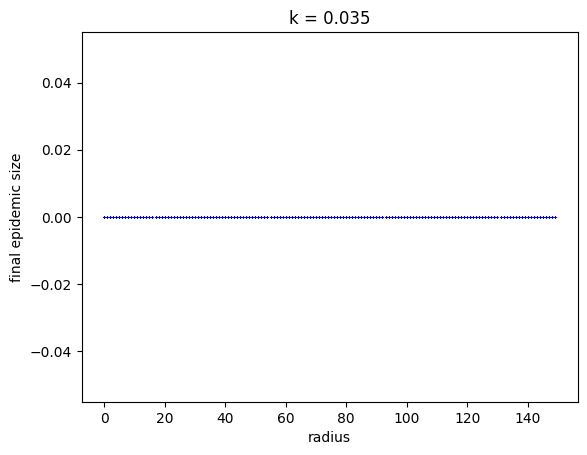

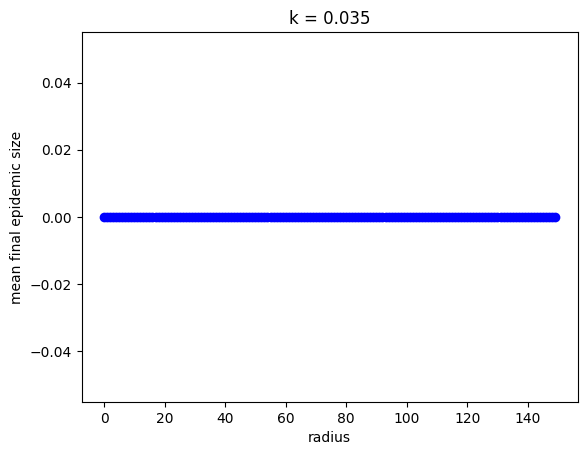

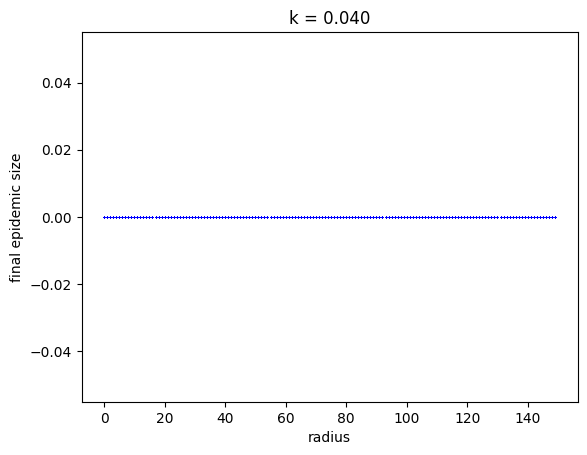

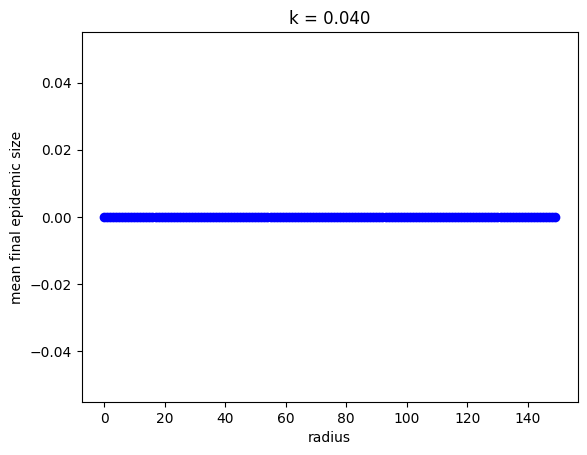

In [8]:
for j in range(len(search)):
    for i in range(max_cull_rad):
        plt.scatter(np.repeat(i, num_repeat), data[j, i, :], color = 'b', s=0.2, alpha=0.02)
    plt.xlabel("radius")
    plt.ylabel("final epidemic size")
    plt.title("k = " + "{:.3f}".format(search[j]))
    plt.show()
    for i in range(max_cull_rad):
        plt.scatter(i, np.average(data[j, i, :]), color = 'b')
    plt.xlabel("radius")
    plt.ylabel("mean final epidemic size")
    plt.title("k = " + "{:.3f}".format(search[j]))
    plt.show()

Alternatively, instead of the cryptic period following the gamma distribution, it is also possible for the probability of detection to follow the logistic progression (or gamma, it is easy to change in the code). Given that we know the time of infection, at each suvey we can calculate the probability of detection precisely and do not require approximation.  Again, below is a code written in python, but is ran more efficiently in julia.

The result with 5000 replications and resolution of 2 is presented below

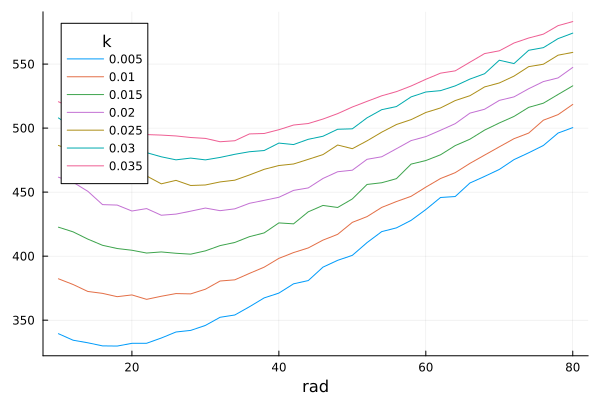

A similar pattern can be observed, with similar overall shape, but detectability that follows a shallower increase in probability of detection (that is, with lower k) have a lower expected final epidemic size given the same control strategy. 

The fuller picture with 1000 repeats and resolution of culling radius of 5 is presented below.

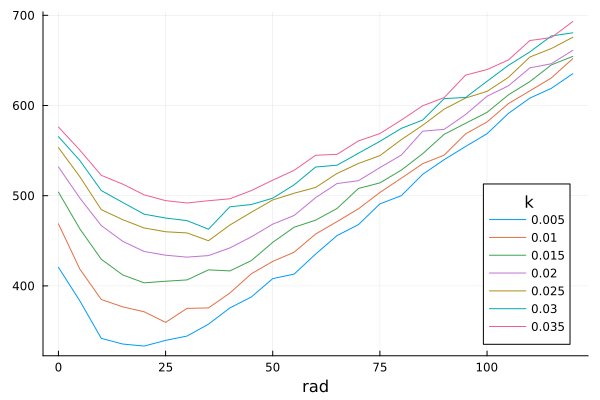

And the code can be found at https://github.com/wl415/Summer-project-on-time-dependent-infectivity-and-detectability/blob/main/Scan%20epidemic%20size%20with%20probabilistic%20detection.jl


In [ ]:
b = 5.25288611787717
a = 37
num_repeat = 100
num_tree = 1111
max_cull_rad = 100
tre = np.loadtxt("smallLandscape.txt")


def inverselogit(y, mu=107, k=0.02, l=1):
    return (-np.log(l / y - 1)/k) + mu


def logit(y, mu, k):
    return 1 / (1 + np.exp(-k * (y - mu)))


# dispersal kernel
def dispersal(alpha):
    dis = ne.evaluate("1/(1+(distance/alpha)**2)")
    factor = (np.sum(dis) - 1111) / 2
    dis = ne.evaluate('dis/factor')
    return b * dis


# pairwise distance matrix
distance = np.zeros([num_tree, num_tree])
for i in range(num_tree):
    for j in range(num_tree):
        distance[i, j] = ((tre[i, 0] - tre[j, 0]) ** 2 + (tre[i, 1] - tre[j, 1]) ** 2) ** 0.5
dispersing = dispersal(37)
dispersing[dispersing < 1e-10] = 0
cull_radiuses = range(max_cull_rad)
search = np.arange(0.005, 0.04, 0.005)
data2 = np.zeros([len(search), max_cull_rad, num_repeat])
for k in search:
    for cull_radius in cull_radiuses:
        for q in range(num_repeat):
            # print(q)
            t = 0
            ts = [0]
            Ss = [1101]
            Cs = [10]
            Rs = [0]
            # data is organised so that tree[:, [0, 1]] is the coordinate, tree[:, 2] is the state with 0 = S, 1 = C, 2 = R
            # tree[:, 3] is the rate of change, or the propagule density that is only applicable to S
            # tree[:, 4] is the time of infection, and tree[:, 5] the time of becoming detectable which in this case is not necessary
            tree = np.c_[tre, np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree)]
            initial = rnd.randint(0, num_tree, 10)
            tree[initial, 2] = 1
            tree[initial, 3] = 0
            # setting initial pressure and time to become detectable
            for i in initial:
                for j in np.where(tree[:, 2] == 0)[0]:
                    tree[j, 3] += dispersing[i, j]

            # loops
            while Cs[-1] > 0:
                # infection
                event = np.cumsum(tree[:, 3])
                rate = event[-1]
                if rate > 0:
                    timestep = rnd.exponential(1 / rate)
                else:
                    break
                nextcull = 90 - (t % 90)
                if nextcull < timestep:
                    t = t + nextcull
                    # culling
                    # list of plant to be culled
                    culled = []
                    # trees are detected according to the probability
                    pdetection = np.zeros(num_tree)
                    pdetection[tree[:, 2] == 1] = logit(t - tree[tree[:, 2] == 1, 4], 107, k)
                    detected = rnd.rand(num_tree) < pdetection
                    for i in np.where(detected == 1)[0]:
                        for j in range(num_tree):
                            # note in this process the detected tree always have distance i, j = 0 and hence is added to the list
                            if distance[i, j] <= cull_radius and tree[j, 2] != 2:
                                culled.append(j)
                    # removing replicates
                    culled = list(dict.fromkeys(culled))
                    # update dispersal stress
                    for i in culled:
                        if tree[i, 2] == 1:
                            for j in range(num_tree):
                                if tree[j, 2] == 0:
                                    tree[j, 3] -= dispersing[i, j]
                    # cull tree
                    tree[culled, 2] = 2
                    tree[culled, 3] = 0
                    ts.append(t)
                    Ss.append(sum(tree[:, 2] == 0))
                    Cs.append(sum(tree[:, 2] == 1))
                    Rs.append(sum(tree[:, 2] == 2))
                    #plt.scatter(tree[tree[:, 2] == 0, 0], tree[tree[:, 2] == 0, 1], color="b", s=0.2)
                    #plt.scatter(tree[tree[:, 2] == 1, 0], tree[tree[:, 2] == 1, 1], color="r", s=0.2)
                    #plt.scatter(tree[tree[:, 2] == 2, 0], tree[tree[:, 2] == 2, 1], color="black", s=0.2)
                    #plt.title(t)
                    #plt.show()
                # infection
                else:
                    t += timestep
                    ts.append(t)
                    whichevent = rate * rnd.rand()
                    which = np.argmax(event > whichevent)
                    tree[which, 2] += 1
                    tree[which, 3] = 0
                    tree[which, 4] = t
                    # updating rate
                    tree[tree[:, 2] == 0, 3] = tree[tree[:, 2] == 0, 3] + dispersing[which, tree[:, 2] == 0]
                    Ss.append(Ss[-1] - 1)
                    Cs.append(Cs[-1] + 1)
                    Rs.append(Rs[-1])
            data2[np.where(k == search), cull_radius, q] = Rs[-1]
    # print(k)

In [ ]:
for j in range(len(search)):
    for i in range(max_cull_rad):
        plt.scatter(np.repeat(i, num_repeat), data2[j, i, :], color = 'b', s=0.2)
    plt.xlabel("radius")
    plt.ylabel("final epidemic size")
    plt.title("k = " + "{:.3f}".format(search[j]))
    plt.show()
    for i in range(max_cull_rad):
        plt.scatter(i, np.average(data2[j, i, :]), color = 'b')
    plt.xlabel("radius")
    plt.ylabel("mean final epidemic size")
    plt.title("k = " + "{:.3f}".format(search[j]))
    plt.show()

Combining the two finding, In both cases, if the mean time of detection is the same, the optimal strategy will be similar. However, if the probability of detection changes more abruptly, then the final epidemic size tends to be higher. 